# 环境测试

In [2]:
import tensorflow  as tf

返回运行时可见的物理设备列表，默认情况下，所有发现的CPU和GPU设备都被视为可见的。

In [3]:
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

查看GPU设备信息

In [4]:
!nvidia-smi

Wed May 13 22:02:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    20W / 175W |    165MiB /  7979MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

检查GPU是否可用

In [5]:
tf.test.is_gpu_available()

True

查看GPU是否可用

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# 启用设备放置日志记录将导致打印任何张量分配或操作
tf.debugging.set_log_device_placement(True)

In [6]:
tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)

VirtualDeviceConfiguration(memory_limit=1024)

# 数据处理

## 数据载入

+ CIFAR-10数据集

&emsp;&emsp;CIFAR-10数据集是一个用于识别普适物体的小型数据集，它一共包含10个类别的RGB彩色图片：飞机（airplane）、汽车（automobile）、鸟类（bird）、猫（cat）、鹿（deer）、狗（dog）、蛙类（frog）、马（horse）、船（ship）和卡车（truck）。图片的尺寸为32x32，该数据集一共有50000张训练图片和10000张测试图片。

&emsp;&emsp;1个10000x3072大小的uint8s数组。数组的每行存储1张32*32的图像,第1个1024包含红色通道值，下1个包含绿色，最后的1024包含蓝色。图像存储以行顺序为主，所以数组的前32列为图像第1行的红色通道值。

In [3]:
import pickle
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
class CIFAR10(object):
    
    def __init__(self,path='/home/wcjb/Code/Dataset/cifar-10-batches-py/'):
        self.trainpath = [os.path.join(path,'data_batch_'+str(i+1)) for i in range(5)]
        self.testpath = [os.path.join(path,'test_batch')]
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding = 'iso-8859-1') # 
        return dict
    
    def load_batch(self,file):
        
        with open(file, 'rb')as f:
            datadict = self.unpickle(file)
            data = datadict['data']
            label = datadict['labels']
            data = data.reshape(10000, 3, 32, 32)
            label = np.array(label)
            return data,label
        
    def toimg(self,data):
        img = []
        for i in range(data.shape[0]):
            imgs = data[i - 1]
            r = imgs[0]
            g = imgs[1]
            b = imgs[2]
            R = Image.fromarray(r)
            G = Image.fromarray(g)
            B = Image.fromarray(b)
            
            img.append(Image.merge("RGB",(R,G,B)))
        return img
            
        
    def cif2img(self):
        
        train_img,test_img = [],[]
    
        for tp in tqdm(self.trainpath,desc='Train-img'):
            
            data,label = self.load_batch(tp)
            train_img.append(self.toimg(data))
            
        for tp in tqdm(self.testpath,desc='Test-img '):
            
            data,label = self.load_batch(tp)
            test_img.append(self.toimg(data))
            
            
        return train_img,test_img
        
    def cif2data(self):
        
        x_train,y_train,x_test,y_test = [],[],[],[]
        for tp in tqdm(self.trainpath,desc='Train'):
        
            data,label = self.load_batch(tp)
            x_train.append(data)
            y_train.append(label)
        for tp in tqdm(self.testpath,desc='Test '):
            data,label = self.load_batch(tp)
            x_test.append(data)
            y_test.append(label)
        x_train,y_train = np.array(x_train).reshape(-1,3,32,32),np.array(y_train).reshape(-1,)
        x_test,y_test = np.array(x_test).reshape(-1,3,32,32),np.array(y_test).reshape(-1,)
        return x_train,y_train,x_test,y_test

In [4]:
cif = CIFAR10()
# 将CIFAR10数据集加载为图片数据
train_img,test_img = cif.cif2img()
# 将将CIFAR10数据集加载为多维数据用于训练
x_train,y_train,x_test,y_test = cif.cif2data()

Test : 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]


## 特征工程

### 查看数据集样本的图片

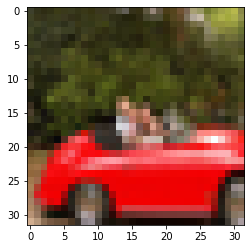

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_img[0][100])

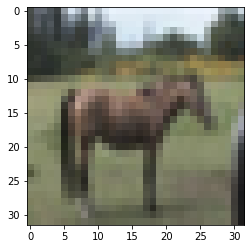

In [20]:
plt.imshow(test_img[0][0])

### 查看数据集的样本的数组形态

In [5]:
x_train.shape

(50000, 3, 32, 32)

# 搭建模型

In [12]:
class network(tf.keras.Model):
    
    def __init__(self):
        
        super(network,self).__init__(name='CIFAR-Model')
        
        self.MODEL_DIR = './models'
        
        self.learning_rate = 1e-4
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        self.conv2d1 = tf.keras.layers.Conv2D(kernel_size=(5,5),filters=100,activation='relu')
        self.maxpool2d1 = tf.keras.layers.MaxPooling2D()
        self.conv2d2 = tf.keras.layers.Conv2D(kernel_size=(3,3),filters=150,activation='relu')
        self.maxpool2d2 = tf.keras.layers.MaxPool2D()
        self.conv2d3 = tf.keras.layers.Conv2D(kernel_size=(3,3),filters=250,padding='same',activation='relu')
        self.maxpool2d3 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512,activation='relu')
        self.dense2 = tf.keras.layers.Dense(300,activation='relu')
        self.predictions = tf.keras.layers.Dense(10,activation='softmax')
        
    def call(self,inputs):
        
        x = self.conv2d1(inputs)
        x = self.maxpool2d1(x)
        x = self.conv2d2(x)
        x = self.maxpool2d2(x)
        x = self.conv2d3(x)
        x = self.maxpool2d3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        predictions = self.predictions(x)
        
        return predictions
    
    def pipline(self,x,y,shuffle_buffer_size=50000,batch_size = 64):
        
        dataset = tf.data.Dataset.from_tensor_slices((x,y))
        # 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
        # 被充分打乱。
        dataset = dataset.shuffle(50000).batch(64)
        
        return dataset
    # 使用静态图转换器将该函数转为静态图显著提升计算速度
    @tf.function
    def trian(self,inputs,outputs):
        
        with tf.device('/GPU:0'):
            with tf.GradientTape(persistent=False,watch_accessed_variables=True) as tape:
                predictions = self.call(inputs)
                loss = tf.keras.losses.SparseCategoricalCrossentropy(predictions,outputs)
                accuracy = tf.keras.metrics.sparse_categorical_accuracy(predictions,outputs)
                grads = tape.gradient(loss,self.train)
                
                
        
        
        

In [14]:
net = network()
net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
           optimizer='adam')